In [33]:
import os.path
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import scipy
from scipy import stats as st
from scipy.integrate import simps
from descriptors import ChebyshevDescriptor 
import pickle as pkl
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchviz import make_dot
from torch.optim import lr_scheduler

# Representative Sampling

#### Optimizing the selection of pct- chromophore snapshots to use as input data for machine learning energy gaps.

# 1. Data Handling and Preproccessing

### 1.1 Reading in the data
The data we are using here is from vaccuum PIMD calculations using various snapshots of the pct- chomophore molecule. The primary data we pull from these jobs is the energy gap between the ground and excited state, as well as the strength of the tranisition dipole moment describing the probability of the excitation occurring.

The data file here is a simple dat text file containing to columns of data: energy gaps and oscillator strength. Using pandas to import the data without any handles results in an unreadable table.



New users to pandas are encouraged to look through this guide walking through the basic functionality and utility of the pandas package.
https://pandas.pydata.org/docs/user_guide/10min.html

In [225]:
pct_data_raw = pd.read_csv('/data/asnider2/shared_data/vacuum_PIMD/traj1/raw_excitations_pct_anion_vac_quantum_nuclei_traj1.dat')
pct_data_raw

,3.32285384\t1.6377
0,3.3629365\t1.7432
1,3.40094782\t1.8328
2,3.42027058\t1.855
3,3.41579075\t1.8102
4,3.3978069\t1.7561
...,...
9994,3.410981\t1.4954
9995,3.38616193\t1.5274
9996,3.36578283\t1.5727
9997,3.34395565\t1.5934


In [226]:
pct_data_DF = pd.read_csv('/data/asnider2/shared_data/vacuum_PIMD/traj1/raw_excitations_pct_anion_vac_quantum_nuclei_traj1.dat',header=None, sep = '\t',names = ['egaps','transition_dipole'])
pct_data_DF

,egaps,transition_dipole
0,3.322854,1.6377
1,3.362936,1.7432
2,3.400948,1.8328
3,3.420271,1.8550
4,3.415791,1.8102
...,...,...
9995,3.410981,1.4954
9996,3.386162,1.5274
9997,3.365783,1.5727
9998,3.343956,1.5934


### 1.2 Data Preproccessing
With two dimensional data, we can utilize plotting tools to look for any iregularities in our dataset

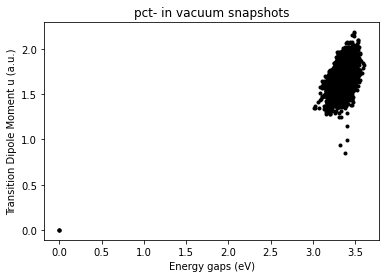

In [227]:
plt.plot(pct_data_DF.egaps,pct_data_DF.transition_dipole, 'k.')
plt.title('pct- in vacuum snapshots')
plt.ylabel('Transition Dipole Moment u (a.u.)')
plt.xlabel('Energy gaps (eV)');

While most of our data falls into the same general grouping, we can clearly visualize some outliers, including several 0 value data points that need to be excluded. 
This is where Pandas really shows its value, as instead of manually scraping the data file to remove the bad data points, we can utilzie boolean indexing to exclude them from the dataset.

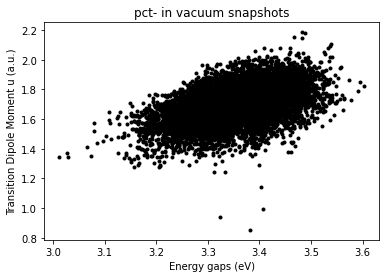

In [228]:
pct_data_DF = pct_data_DF[pct_data_DF.egaps !=0]
plt.plot(pct_data_DF.egaps,pct_data_DF.transition_dipole, 'k.')
plt.title('pct- in vacuum snapshots')
plt.ylabel('Transition Dipole Moment u (a.u.)')
plt.xlabel('Energy gaps (eV)');

We can take this further by eliminating less extreme outliers from our dataset. One can make a cutoff based on the value of the transition dipole moment to try and exclude transitions that don't correspond to the desired S0 -> S1 transition.

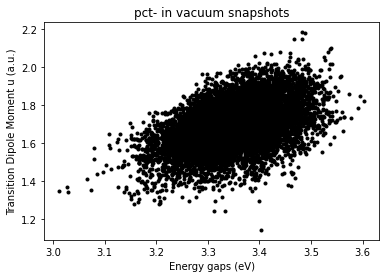

In [229]:
transition_dipole_cutoff = 1.1
pct_data_cleaned = pct_data_DF[pct_data_DF.transition_dipole >= transition_dipole_cutoff]
pct_data_cleaned = pct_data_cleaned.reset_index()
plt.plot(pct_data_cleaned.egaps,pct_data_cleaned.transition_dipole, 'k.')
plt.title('pct- in vacuum snapshots')
plt.ylabel('Transition Dipole Moment u (a.u.)')
plt.xlabel('Energy gaps (eV)');

### 1.3 Transformation and Sampling
Now that we have our cleaned data, lets discuss sampling from this ensemble. 

First, lets pick out 100 random data points from our full set.

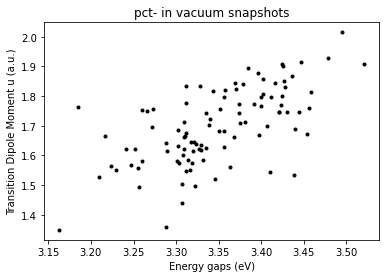

In [230]:
rand_index = np.random.randint(0,10000,100)
plt.plot(pct_data_cleaned.egaps[rand_index],pct_data_cleaned.transition_dipole[rand_index], 'k.')
plt.title('pct- in vacuum snapshots')
plt.ylabel('Transition Dipole Moment u (a.u.)')
plt.xlabel('Energy gaps (eV)');

How can we tell if our subset accurately represents the full ensemble? Since our goal is to eventually recreate the full spectra, we can't simply look at average values, we need a method that takes into account the spacing and layout of the data. In order to get a metric to do just that, we reform our datapoints into kernels using a Multivariate Gaussian Kernel Estimation approach.

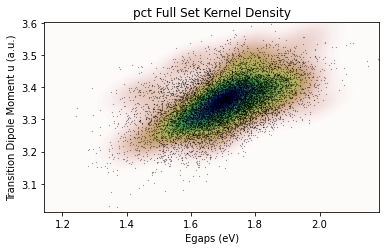

In [301]:
m1 = pct_data_cleaned.transition_dipole
m2 = pct_data_cleaned.egaps
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = st.gaussian_kde(values)
Z_full = np.reshape(kernel(positions).T, X.shape)
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=0.3)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.title('pct Full Set Kernel Density')
plt.xlabel('Egaps (eV)')
plt.ylabel('Transition Dipole Moment u (a.u.)')
plt.show()


Now we can compare the distribution of any subset data with the distribution of the full ensemble. By using the difference in distributions as our loss function, we can employ any standard machine learning optimiziation method to try and optimize the subset selection. First, we need to add the code to calculate the Kullback–Leibler Divergence between our subset and the full dataset.

In [288]:
def KL_div(P,Q,X,Y): # P is target distribution (full sample) Q is random subset sample that we are optimizing
    integrand  = P * np.log(P/Q) + Q - P
    integral = simps([simps(Z_x,X) for Z_x in integrand],Y)
    return integral

Kullback–Leibler Divergence, $D_{KL}(P || Q)$,is a measure of statistical distance between two disributions. Also known as relative entropy, KL divergence can be interpreted as the information content lost when approximating one PDF with another.

We can test out our new loss function with a randomly selected distribution:

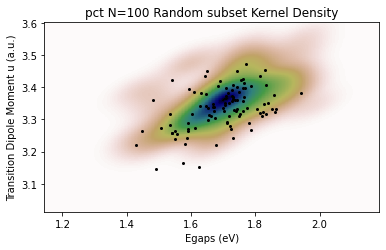

Kullback–Leibler Divergence from full ensemble: 0.14190403655233885


In [299]:
rand_index = np.random.randint(0,10000,100)
m1 = pct_data_cleaned.transition_dipole[rand_index]
m2 = pct_data_cleaned.egaps[rand_index]
values = np.vstack([m1, m2])
kernel = st.gaussian_kde(values)
Z_subset = np.reshape(kernel(positions).T, X.shape)
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=4)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.title('pct N=100 Random subset Kernel Density')
plt.xlabel('Egaps (eV)')
plt.ylabel('Transition Dipole Moment u (a.u.)')
plt.show()
print('Kullback–Leibler Divergence from full ensemble:',KL_div(Z_full,Z_subset,x,y))

By running the above cell in place (ctrl + enter) repeatedly, you can see how the subset distribution varies as we generate different random subsets. It can be an interesting visual exercise to see which areas of the plot change, and what areas stay mostly consistent across the different subsets.

# 2. Representative Sampling 

### 2.1 Trial Simulation
A key part of the Simulaed Annealing process is selecting an initial temperature. The temperature is the main variable that affects the optimization process: at higher temps unfavorable moves uphill (a.k.a to a higher loss function value) are more likely to occur. As we lower the temperature, these moves have a lower probability of occurrence. To get an idea of what to set our initial temperature to, we will sample the loss function surface by calculating the KL divergence of several thousand randomly selected subsets and comparing them to the full ensemble.

In [235]:
def random_sample(m1,m2,subset_size = 50):
    rand_index = list(np.random.randint(0,m1.size,subset_size))
    #print(rand_index)
    m1_new = m1.loc[rand_index]
    m2_new = m2.loc[rand_index]
    
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()

    x = np.linspace(xmin,xmax,100)
    y = np.linspace(ymin,ymax,100)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1_new, m2_new])
    kernel = st.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)  

    return Z,rand_index

def sample_element_swap(S_index,m1_full,m2_full):
    swap_idx = np.random.randint(0,len(S_index))
    unused_index = [i for i in range(0,m1_full.size) if i not in S_index]
    rand_index_new = np.random.choice(unused_index)
    S_index[swap_idx] = rand_index_new
    m1_current = m1_full[S_index]
    m2_current = m2_full[S_index]
    
    xmin = m1_full.min()
    xmax = m1_full.max()
    ymin = m2_full.min()
    ymax = m2_full.max()

    x = np.linspace(xmin,xmax,100)
    y = np.linspace(ymin,ymax,100)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1_current, m2_current])
    kernel = st.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)  

    return Z,S_index



def trial_sim(df,N,subset_size = 50,plot=False):
    dkls = np.ones(N)
    ddkls = np.ones(N)
    egaps = df.egaps
    u = df.transition_dipole
    x = np.linspace(u.min(),u.max(),100)
    y = np.linspace(egaps.min(),egaps.max(),100)
    Z_full  = dist_gen_spec(df)[0]
    Z_rand,ini_idx = random_sample(u,egaps,subset_size)
    for i in range(N):
        ddkl = 0
        if i == 0:
            Z_k = Z_rand #sample_element_swap(Z_rand,ini_idx,Z_true)
            dkl = KL_div(Z_full,Z_k,x,y)
            dkls[i] = dkl
            dkl_old = dkl
            old_idx = ini_idx

        else:
            Z_k,new_idx = sample_element_swap(old_idx,u,egaps)
            dkl = KL_div(Z_full,Z_k,x,y)
            dkl_new = dkl
            dkls[i] = dkl        
            ddkl = np.abs(dkl_new - dkl_old)
            ddkls[i] = ddkl
            dkl_old = dkl_new
            old_idx = new_idx
        #if i % 100 ==0:
            #print('step',i,' current Dkl = ',dkl_old)


    print('min Dkl difference: ',ddkls[1:].min(),' max Dkl difference: ', ddkls[1:].max())
    ddkls_min = ddkls[1:].min() 
    ddkls_max = ddkls[1:].max()
    T_initial  = -ddkls_max / np.log(0.9) # using 0.9 as initial probability
    T_final  = -ddkls_min / np.log(0.1) # using 0.1 as final probability
    print('Reccomended Initial Temp: ',T_initial,' Reccomended Final Temp: ',T_final)
    if plot == True:
        plt.title('Kullback-Leiber Divergence for Multivariate Distribution')
        plt.ylabel('D_kl')
        plt.xlabel('# of iterations')
        plt.plot(dkls)
    return(T_initial,T_final)

min Dkl difference:  9.083729281961217e-07  max Dkl difference:  0.029536254321479258
Reccomended Initial Temp:  0.2803351344388117  Reccomended Final Temp:  3.945013502258745e-07


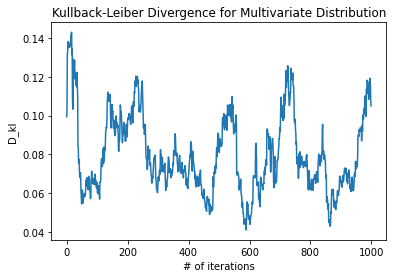

In [237]:
pct_trial_sim = trial_sim(pct_data_cleaned,N=1000,subset_size=100,plot=True)

If we take the simulation above to be representative of the loss function surface, it is immediately clear why the use of metahueristic optimization is required. The jagged surface with a large number of local minima make it near impossible to reach close to the global minimum using derivative based steps. A typical gradient descent approach would quickly get stuck in any one of the function valleys without making much progress.


### 2.2 The Simulated Annealing Algorithm
Below is a general description of the simulated annealing (SA) optimization procedure, as well as the actual python code to run it. Ignoring the parts handling the transformation of the data into a 2D kernel distribution, the algorithm itself is rather simple and concise in nature. 

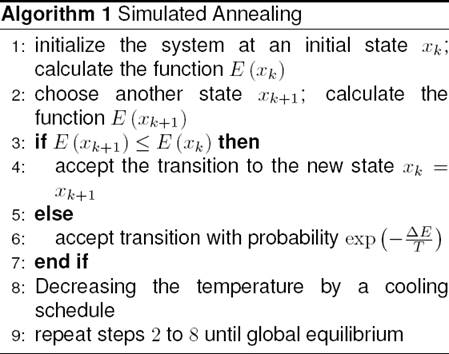


In our case the objective function is the KL divergence between a subset and the full ensemble so the probability of accepting a 'bad' step is: 
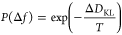

In [239]:
def SA_Simulate(df,Temps,iter_number,alpha=0.95,subset_size = 100,thresh = 0.025,cooling_schedule='geometric',plot = True):

    dkls = []
    ddkls = []
    probability = []
    Tks = []
    egaps = df.egaps
    u = df.transition_dipole
    x = np.linspace(u.min(),u.max(),100)
    y = np.linspace(egaps.min(),egaps.max(),100)
    Z_full  = dist_gen_spec(df)[0]
    Z_ini,ini_idx = random_sample(u,egaps,subset_size)
    dkl_old = KL_div(Z_full,Z_ini,x,y)
    Tk = Temps[0]  #initialize temp
    T_f = Temps[1] #set temp cutoff, stops iteration when reached
    old_idx = ini_idx
    count = 0 # iteration count
    k = 1 # cooling cycle count
# SA algorithm start
###############################################################################################################
    while Tk > T_f: # outer loop controls cooling schedule
        for i in range(iter_number): # inner loop tells algorithm how many new configurations to try at each temperature
            Z_k,new_idx = sample_element_swap(old_idx,u,egaps) #swaps one random subset snapshot with another from the full ensemble
            dkl_new = KL_div(Z_full,Z_k,x,y) #calculate KL divergence of new subset
            ddkl = dkl_new - dkl_old # compare divergence to old subset
            if ddkl < 0: # if difference is negative, automatically accept new subset
                dkls.append(dkl_new)
                dkl_old = dkl_new
                old_idx = new_idx
            elif np.random.uniform(0, 1) < np.exp(-ddkl / Tk): # if difference is positive, randomly accept with temperature driven probability
                probability.append(np.exp(-ddkl / Tk))
                dkls.append(dkl_new)
                dkl_old = dkl_new
                old_idx = new_idx
            count += 1 
            if count % 50 ==0:
                print('Step: ',count,' Dkl: ',dkl_old)
            if dkl_old < thresh:
                Tk = T_f
        if cooling_schedule == 'geometric':# 0.8 < alpha < 0.95
            Tk = alpha*Tk
        if cooling_schedule == 'linear': # alpha > 0
            Tk = Temps[0]/(1+alpha*k)
        if cooling_schedule == 'exponential': # 0.8 < alpha < 0.9
            Tk = Temps[0]*alpha**k
        Tks.append(Tk)
        k +=1
###############################################################################################################
    if plot ==True:
        plt.title('Simulated Annealing for Optimization of pCT Snapshots')
        plt.ylabel('D_kl')
        plt.xlabel('# of iterations')
        plt.plot(dkls)
    dkl_final = dkls[-1]
    idx_final  = new_idx
    print('Dkl of optimized subset: ',dkl_final)
    return(idx_final)

Based on the choice of cooling schedule and associated hyperpariter_number=rs, the optimization process can take quite a bit of time. Adjusting the cooling schedule to decrease at a faster rate shortens the convergence time, but might lead to insufficient exploration of the configuration space, resulting in a poorer approximation of the global minimum. However in cases where some flexability of the final solution is tolerable, reducing optimization time may be the more optimal play. In the function call below, try setting up either a geometric or exponential cooling schedule with an alpha value between 0.7 and 0.8.

In [ ]:
SA_sim_pct_practice = SA_Simulate(pct_data_cleaned,pct_trial_sim,iter_number=50,alpha=___,cooling_schedule=___)

For a realistic simulation, we would generally want to choose alpha to be between 0.90 and 0.99 in order to search through a larger number of possible subset configurations. The optimization setup below typically runs between 30 minutes to an hour depending on if we get lucky with the convergence.

Step:  50  Dkl:  0.09803849128278357
Step:  100  Dkl:  0.06956876350667547
Step:  150  Dkl:  0.09687742169686296
Step:  200  Dkl:  0.12006793026345892
Step:  250  Dkl:  0.12293550610795623
Step:  300  Dkl:  0.11930880565803166
Step:  350  Dkl:  0.09831738792001957
Step:  400  Dkl:  0.06490614904004229
Step:  450  Dkl:  0.0650289556503519
Step:  500  Dkl:  0.09215720913832431
Step:  550  Dkl:  0.0670944192517274
Step:  600  Dkl:  0.07051023746194045
Step:  650  Dkl:  0.09853557111333064
Step:  700  Dkl:  0.07377166113853666
Step:  750  Dkl:  0.12226201086447047
Step:  800  Dkl:  0.10641541699344804
Step:  850  Dkl:  0.1129223582207036
Step:  900  Dkl:  0.07958565442054558
Step:  950  Dkl:  0.08153695857449181
Step:  1000  Dkl:  0.06110880629345463
Step:  1050  Dkl:  0.09298519364708459
Step:  1100  Dkl:  0.09729118806353157
Step:  1150  Dkl:  0.09004243423149656
Step:  1200  Dkl:  0.09993080880775124
Step:  1250  Dkl:  0.061910524622860674
Step:  1300  Dkl:  0.058796414935583956
Step:  

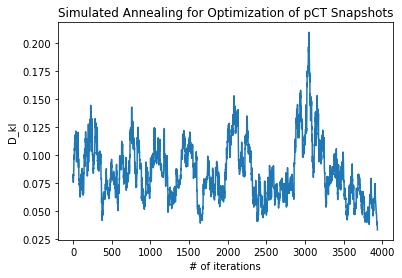

In [105]:
SA_index_pct = SA_Simulate(pct_data_cleaned,pct_trial_sim,alpha=0.95,iter_number=50,cooling_schedule='geometric')

In [98]:
pct_opt_index = [9635,6826,225,5853,446,5387,9655,1413,9779,8024,3091,7408,2903,8118,341,8842,4859,726,1260,5152,9231,4917,7535,5079,634,9118,2154,1187,6498,7917,3911,4139,6727,1813,6471,8589,8401,4313,3140,8844,5758,6696,9055,1837,3836,6178,7778,4958,49,4365]

In the original paper where this method was published, the optimized snapshots were taken and the energies were recalculated at a higher level of theory, using a basis set and DFT functional that would have been computationally prohibitive to run for the full ensemble. The higher quality data was used to generate absorption spectra that were compared with experimental results for method validation.

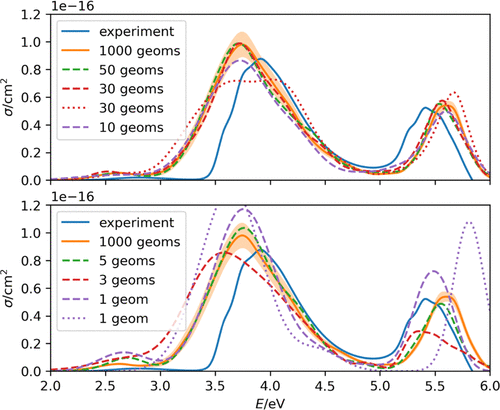


S. Sršeň, P. Slavíček. Optimal Representation of the Nuclear Ensemble: Application to Electronic Spectroscopy. J. Chem. Theory Comput. 2021, 17, 10, 6395–6404

DOI: 10.1021/acs.jctc.1c00749


Instead, our goal is to use the optimized subset as training data for our energy gap ML model. 

### 3. Machine Learning Magic
The following portion of the notebook concerns taking the preselected chromophore, converting the nuclear coordinates and energy gaps into a given descriptor space, and training a deep learning network built using PyTorch. For comparison sake we will train two models, one using randomly selected snapshots and one using our optimized subset. 

### 3.1 Descriptor Creation
If you have ever submitted a Gaussian,Qchem,Terachem, or Octopus job, you have likely seen a file containing nuclear coordinates that serve as the basic input for electronic structure software. Ideally, we could find an easy way to plug nuclear coordinates into a neural network's input nodes. In reality, we have to take special steps to insure that our inputs are translationally and rotationally invariant. Using chebyshev polynomials, we map the nuclear coordinates of a given snapshot to a special atom-centered symmetry function whose value depends on the coordinates of the atom as well as the type and location of other atoms within a certain cutoff radius of the original atom. These symmetry functions are designed to encode, in addition to the structure, important properties of the potential-energy surface like its invariances with respect to rotation, translation and permutation of like atoms.

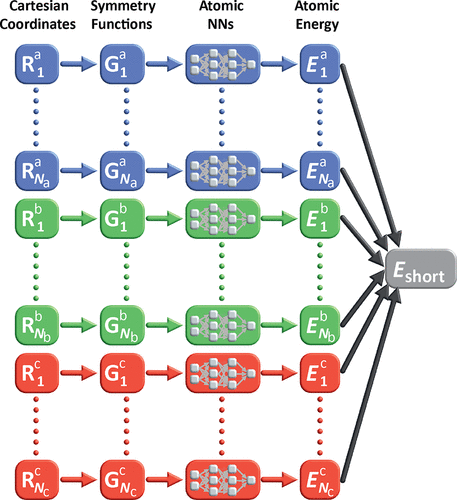

In [112]:
# create the test set
rand_test= []
while len(rand_test) < 50:
    r = np.random.randint(0,len(pct_data_cleaned))
    if (r not in rand_index) and (r not in SA_index_pct):
            rand_test.append(r)

In [157]:
# Setup Chebyshev descriptor parameters for pCT-
wt_map = {'H': -2.0, 'C': -1.0, 'O': 1.0, 'S': 2.0}
ind_map = {'H': 0, 'C': 1, 'O': 2, 'S': 3}
ang_Rc, rad_Rc = 5.00, 15.00
ang_N, rad_N = 3, 6
descrs = ChebyshevDescriptor(rad_Rc, ang_Rc, rad_N, ang_N, wt_map, ind_map, 'cos')

# Load pCT- in vacuum dataset
configs = pkl.load(open('pct_vac_traj1.p','rb'))
nsnaps = len(configs)

print('no of snapshots',nsnaps)
# Create a pytorch tensor of the atomic positions for the first configuration
x = torch.as_tensor(configs[0]['pos'], dtype=torch.float64)

# Calculate Chebyshev descriptors for the first configuration in the dataset
# Note 'lat' is None to indicate that we are note doing periodic boundary conditions
# G is (natoms x ndescriptors)
G = descrs.calc_descriptor(x, configs[0]['elems'], None)
G = torch.tensor(np.zeros((nsnaps,G.shape[0],G.shape[1])))
y = torch.tensor(np.zeros((nsnaps,1)))
elem = []
count=0
for i in range(nsnaps):
    x = torch.as_tensor(configs[i]['pos'], dtype=torch.float64)
    G[count,:,:] = descrs.calc_descriptor(x, configs[i]['elems'], None)
    y[count] = torch.as_tensor(configs[i]['energy'], dtype=torch.float64)
    elem.append(configs[i]['elems'])
    count +=1
print(G.shape)

no of snapshots 9994
torch.Size([9994, 29, 22])


In [158]:
def mydataloader(snaplist,X,Y,e):
    l=[]
    for i in snaplist:
        X1 = X[i,:]
        Y1 = Y[i]
        #print(Y1.shape)
        l.append((X1,Y1,e[i]))
    return l
dataTrain_rand=mydataloader(rand_index,G,y,elem)
dataTrain_opt=mydataloader(SA_index_pct,G,y,elem)
dataTest=mydataloader(rand_test,G,y,elem)

### 3.2 Model Setup

In [160]:
class NNP(nn.Module):
    """Neural Network representing one atom/element"""
    def __init__(self,natoms,nfunc,nhidden,noutput):
          super(NNP, self).__init__()

         #For a given chemical element, 
         #the architectures and the weight parameters of the atomic NNs are identical, i.e., 
         #the sets of NN weights to be fitted correspond to the number of chemical species in the system.
          self.nfunc = nfunc
          self.natoms = natoms
          self.nhidden = nhidden
          self.noutput = noutput
          self.C = nn.Sequential(nn.Linear(self.nfunc,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.noutput))
          self.S = nn.Sequential(nn.Linear(self.nfunc,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.noutput))
          self.O = nn.Sequential(nn.Linear(self.nfunc,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.noutput))
          self.H = nn.Sequential(nn.Linear(self.nfunc,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.nhidden),
                                 nn.Tanh(),
                                 nn.Linear(self.nhidden,self.noutput))
    def forward(self,x,elements):
        ypred=0
        for i in range(self.natoms):
            if elements[i] == 'C': 
                a = self.C(x[i])
            if elements[i] == 'S': 
                a = self.S(x[i])
            if elements[i] == 'H': 
                a = self.H(x[i])
            if elements[i] == 'O': 
                a = self.O(x[i])
            ypred += a 
        return ypred

In [161]:
model_rand = NNP(29,22,25,1).double()
print(model_rand)

NNP(
  (C): Sequential(
    (0): Linear(in_features=22, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
  (S): Sequential(
    (0): Linear(in_features=22, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
  (O): Sequential(
    (0): Linear(in_features=22, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
  (H): Sequential(
    (0): Linear(in_features=22, out_features=2

In [162]:
for name, param in model_rand.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
optimizer = torch.optim.Adam(model_rand.parameters(), lr=1e-6)

Layer: C.0.weight | Size: torch.Size([25, 22]) | Values : tensor([[ 0.1665,  0.0741, -0.0817, -0.1341, -0.0859,  0.0930,  0.0304, -0.2023,
         -0.1646,  0.0947,  0.0867,  0.0503, -0.2028,  0.1138, -0.0902, -0.1927,
          0.0219, -0.0337, -0.1411,  0.0715,  0.1223, -0.0350],
        [-0.0014,  0.0913,  0.1944, -0.0765,  0.0495, -0.1856, -0.1081, -0.0298,
          0.0240,  0.1566, -0.1114,  0.2041,  0.1566,  0.1459,  0.2043,  0.1620,
          0.2094,  0.0355,  0.0066, -0.0011,  0.0770,  0.0735]],
       dtype=torch.float64, grad_fn=<SliceBackward0>) 

Layer: C.0.bias | Size: torch.Size([25]) | Values : tensor([-0.1932,  0.1379], dtype=torch.float64, grad_fn=<SliceBackward0>) 

Layer: C.2.weight | Size: torch.Size([25, 25]) | Values : tensor([[ 0.1154,  0.0537, -0.1734, -0.0692,  0.0076,  0.0397,  0.1699, -0.0854,
         -0.0228, -0.0174, -0.0691, -0.1649,  0.0181,  0.1474, -0.1068, -0.1019,
         -0.1105, -0.0456,  0.0420,  0.1956, -0.0020, -0.1940,  0.1032,  0.0391,
    

In [163]:
def trainloop(data,model,lossfn,optimizer):
    trainloss=0
    ntot = len(data)
    for i, item in enumerate(data):
        X, Y, elem = iter(item)
        #Forward pass
        y_pred = model(X,elem)
        #print(y_pred.shape)
        loss = lossfn(y_pred,Y)
        # set the gradients to zero
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
    return trainloss/ntot    
def testloop(data,model,lossfn):
    testloss =0
    ntot = len(data)
    with torch.no_grad():
        for i, item in enumerate(data):
            X, Y, elem = iter(item)
            y_pred = model(X,elem)
            #print(y_pred.shape)
            loss = lossfn(y_pred,Y)
            testloss += loss.item()
    return testloss/ntot

### 3.3 Model Training
Skip to section 3.4 for loading pretrained models.

In [164]:
nepochs=2000
rand_trainL=[]
mse_loss = nn.MSELoss(reduction='mean') #Loss
for epoch in range(1,nepochs+1):
    trainloss = trainloop(dataTrain_rand,model_rand,mse_loss,optimizer)
    testloss = testloop(dataTest,model_rand,mse_loss)
    if epoch % 1 == 0:
        print('Epoch: {}/{}.............'.format(epoch, nepochs), end=' ')
        print("Train Loss: {:.8e}".format(trainloss),end=' ')
        print("Test Loss: {:.8e}".format(testloss))
        for param_group in optimizer.param_groups:
            print("Learning rate: {:.8e}".format(param_group['lr']))
        rand_trainL.append((epoch,trainloss,testloss))
    #if epoch%100 == 0:
        #saveChckPnt(epoch,model_rand,optimizer,trainloss)

Epoch: 1/2000............. Train Loss: 6.66214016e+01 Test Loss: 6.53936707e+01
Learning rate: 1.00000000e-06
Epoch: 2/2000............. Train Loss: 6.39791308e+01 Test Loss: 6.27792224e+01
Learning rate: 1.00000000e-06
Epoch: 3/2000............. Train Loss: 6.14164945e+01 Test Loss: 6.02428435e+01
Learning rate: 1.00000000e-06
Epoch: 4/2000............. Train Loss: 5.89299247e+01 Test Loss: 5.77815689e+01
Learning rate: 1.00000000e-06
Epoch: 5/2000............. Train Loss: 5.65166089e+01 Test Loss: 5.53927390e+01
Learning rate: 1.00000000e-06
Epoch: 6/2000............. Train Loss: 5.41739732e+01 Test Loss: 5.30738627e+01
Learning rate: 1.00000000e-06
Epoch: 7/2000............. Train Loss: 5.18996014e+01 Test Loss: 5.08225959e+01
Learning rate: 1.00000000e-06
Epoch: 8/2000............. Train Loss: 4.96912316e+01 Test Loss: 4.86367581e+01
Learning rate: 1.00000000e-06
Epoch: 9/2000............. Train Loss: 4.75467843e+01 Test Loss: 4.65143703e+01
Learning rate: 1.00000000e-06
Epoch: 10/

In [184]:
model_opt = NNP(29,22,25,1).double()
optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=1e-6)
opt_trainL=[]
for epoch in range(1,nepochs+1):
    trainloss_opt = trainloop(dataTrain_opt,model_opt,mse_loss,optimizer_opt)
    testloss_opt = testloop(dataTest,model_opt,mse_loss)
    if epoch % 1 == 0:
        print('Epoch: {}/{}.............'.format(epoch, nepochs), end=' ')
        print("Train Loss: {:.8e}".format(trainloss_opt),end=' ')
        print("Test Loss: {:.8e}".format(testloss_opt))
        for param_group in optimizer.param_groups:
            print("Learning rate: {:.8e}".format(param_group['lr']))
        opt_trainL.append((epoch,trainloss_opt,testloss_opt))

Epoch: 1/2000............. Train Loss: 7.99314609e+00 Test Loss: 7.50156025e+00
Learning rate: 1.00000000e-06
Epoch: 2/2000............. Train Loss: 7.13351937e+00 Test Loss: 6.68049060e+00
Learning rate: 1.00000000e-06
Epoch: 3/2000............. Train Loss: 6.34442863e+00 Test Loss: 5.92790965e+00
Learning rate: 1.00000000e-06
Epoch: 4/2000............. Train Loss: 5.62184564e+00 Test Loss: 5.23987218e+00
Learning rate: 1.00000000e-06
Epoch: 5/2000............. Train Loss: 4.96194360e+00 Test Loss: 4.61263389e+00
Learning rate: 1.00000000e-06
Epoch: 6/2000............. Train Loss: 4.36106707e+00 Test Loss: 4.04260795e+00
Learning rate: 1.00000000e-06
Epoch: 7/2000............. Train Loss: 3.81570583e+00 Test Loss: 3.52634381e+00
Learning rate: 1.00000000e-06
Epoch: 8/2000............. Train Loss: 3.32247841e+00 Test Loss: 3.06051349e+00
Learning rate: 1.00000000e-06
Epoch: 9/2000............. Train Loss: 2.87812016e+00 Test Loss: 2.64190075e+00
Learning rate: 1.00000000e-06
Epoch: 10/

In [269]:
steps = np.zeros(nepochs)
trainLoss_rand = np.zeros(nepochs)
trainLoss_opt = np.zeros(nepochs)
testLoss_rand = np.zeros(nepochs)
testLoss_opt = np.zeros(nepochs)


def predict(X,ele,model):
    ypred=model(X,ele)
    return ypred

### 3.4 Pretrained Models
To save a few hours of model training, we can skip ahead and load up the trained models and their learning curves.

In [281]:
pct_opt_model = NNP(29,22,25,1).double()
pct_opt_model.load_state_dict(torch.load('pct_vac_SA_100_v2.chk'))
pct_rand_model = NNP(29,22,25,1).double()
pct_opt_model.load_state_dict(torch.load('pct_vac_rand_100.chk'))

rand_traincurve = np.load('pct_rand_100_traincurve_lr=1e-06.npz')
opt_traincurve = np.load('pct_opt_100_traincurve_lr=1e-06.npz')
trainLoss_rand = rand_traincurve['trainLoss']
testLoss_rand = rand_traincurve['testLoss']
trainLoss_opt = opt_traincurve['trainLoss']
testLoss_opt = opt_traincurve['testLoss']

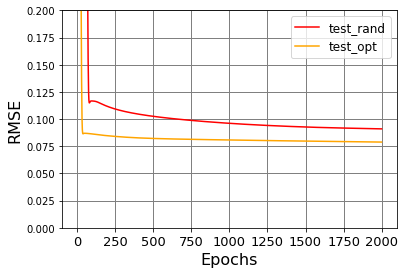

In [285]:

plt.figure()
#plt.plot(np.sqrt(trainLoss_rand),'b',label='train_rand')
plt.plot(np.sqrt(testLoss_rand),'r',label='test_rand')
#plt.plot(np.sqrt(trainLoss_opt),'g',label='train_opt')
plt.plot(np.sqrt(testLoss_opt),'orange',label='test_opt')
plt.ylim([0,0.2])
fontprop = fm.FontProperties(size=12); #Using different fonts
plt.legend(prop=fontprop)                                                #Formatting legend
plt.grid(color='gray', linestyle='-', linewidth=1);
plt.xlabel("Epochs", fontproperties=fontprop, fontsize=16)           #Formatting X axis label
plt.ylabel("RMSE", fontproperties=fontprop, fontsize=16)  #Formatting Y axis label
plt.xticks(fontproperties=fontprop,fontsize=13)    ;

We can also evaluate how well our models learned to predict the energy gaps of various snapshots. The Root Mean Square Error (RMSE) gives us a quantative metric to measure our model's performance on both the training and test datasets.

Train RMSE (eV): 0.06751801
Test RMSE (eV): 0.09099547


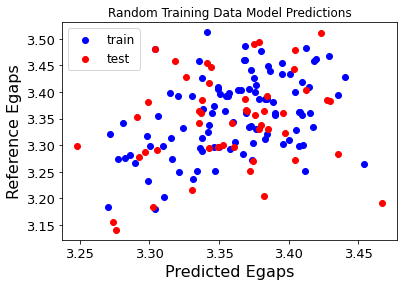

In [284]:
yprTrain = np.zeros(100)
yrefTrain = np.zeros(100)
yprTest = np.zeros(50)
yrefTest = np.zeros(50)
for i, item in enumerate(dataTrain_rand):
    #print(i)
    X, Y,ele = iter(item)
    yprTrain[i] = predict(X,ele,model_rand).detach().numpy()
    yrefTrain[i] = Y.detach().numpy()
for i, item in enumerate(dataTest):
    X, Y,ele = iter(item)
    yprTest[i] = predict(X,ele,model_rand).detach().numpy()
    yrefTest[i] = Y.detach().numpy()
plt.figure()
plt.scatter(yprTrain,yrefTrain,c="b",label='train')
plt.scatter(yprTest,yrefTest,c="r",label='test')

fontprop = fm.FontProperties(size=12) #Using different fonts
plt.legend(prop=fontprop)                                                   #Formatting legend
#plt.ylim(0.0,0.14)
#plt.xlim(2.3,3.3)
plt.xlabel("Predicted Egaps", fontproperties=fontprop, fontsize=16)            #Formatting X axis label
plt.ylabel("Reference Egaps", fontproperties=fontprop, fontsize=16)  #Formatting Y axis label
plt.xticks(fontproperties=fontprop,fontsize=13)                            #Formatting the x axis ticks
plt.yticks(fontproperties=fontprop, fontsize=13)                        #Formatting the Y axis ticks
plt.title('Random Training Data Model Predictions')
#print(ypr,yref)

train = np.sqrt(np.mean(np.square(yprTrain - yrefTrain)))
test = np.sqrt(np.mean(np.square(yprTest - yrefTest)))

print('Train RMSE (eV): %.8f' % (train))
print('Test RMSE (eV): %.8f' % (test))

Train RMSE (eV): 0.04860541
Test RMSE (eV): 0.07885346


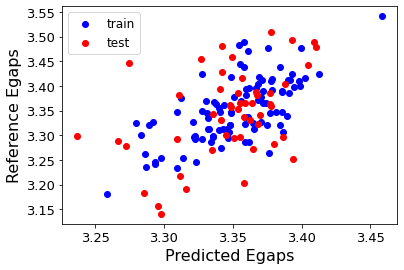

In [278]:
yprTrain = np.zeros(100)
yrefTrain = np.zeros(100)
yprTest = np.zeros(50)
yrefTest = np.zeros(50)
for i, item in enumerate(dataTrain_opt):
    #print(i)
    X, Y,ele = iter(item)
    yprTrain[i] = predict(X,ele,pct_opt_model).detach().numpy()
    yrefTrain[i] = Y.detach().numpy()
for i, item in enumerate(dataTest):
    X, Y,ele = iter(item)
    yprTest[i] = predict(X,ele,pct_opt_model).detach().numpy()
    yrefTest[i] = Y.detach().numpy()
plt.figure()
plt.scatter(yprTrain,yrefTrain,c="b",label='train')
plt.scatter(yprTest,yrefTest,c="r",label='test')

fontprop = fm.FontProperties(size=12) #Using different fonts
plt.legend(prop=fontprop)                                                   #Formatting legend
#plt.ylim(0.0,0.14)
#plt.xlim(2.3,3.3)
plt.xlabel("Predicted Egaps", fontproperties=fontprop, fontsize=16)            #Formatting X axis label
plt.ylabel("Reference Egaps", fontproperties=fontprop, fontsize=16)  #Formatting Y axis label
plt.xticks(fontproperties=fontprop,fontsize=13)                            #Formatting the x axis ticks
plt.yticks(fontproperties=fontprop, fontsize=13)                        #Formatting the Y axis ticks
plt.savefig('RefvsPre5e-05_rand_sample_400.png', dpi=600, bbox_inches='tight')
#print(ypr,yref)

train = np.sqrt(np.mean(np.square(yprTrain - yrefTrain)))
test = np.sqrt(np.mean(np.square(yprTest - yrefTest)))

print('Train RMSE (eV): %.8f' % (train))
print('Test RMSE (eV): %.8f' % (test))